In [3]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()

# plates = [
# "111_20240131",
# "179_20240219",
# "199_20240130",
# "393_20231129",
# "401_20231123",
# "404_20231127",
# "407_20240102"
# ]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
plates = [
    '1014_20220525', '1023_20220502',
          '1042_20220523',
       '1045_20220504', '1048_20220506',
          '1076_20220511',
          # '152_20201224',
          "3_20220426",
    "12_20220502",
    "16_20220419",
    "480_20221205", 
    '52_20220707',
          # '76_20210108',
       # '792_20210915',
    # '799_20211001', 
    # '800_20210928',
          '84_20220621',
    '91_20220708',
    '938_20220325',
          # '94_20201123'
         ]
plates += ["28_20230227",
"206_20230303",
"202_20230314",
"218_20230227",
"219_20230307",
"229_20230330",]
plates += ["527_20230106","537_20230111"]
plates += ["462_20221013"]
plates += ["532_20220104"]
plates += [
"249_20230324",
"241_20230403",
"252_20230316",
"248_20230320",
]
plates += ["510_20221201",
           "521_20230104",
           "530_20230115"
          ]
plates += [
          "558_20230109",
          "552_20230111",
          "551_20220102",
          "540_20221227",
]
plates += [
        "559_20230109", 

          "544_20230109",
          "531_20221222",
]
plates += [
         "514_20221206",
         "513_20221205",
         "506_20221124",
         "472_20221003"
          ]
plates += [
          "558_20230109",
          "552_20230111",
          "551_20220102",
          "540_20221227",
]
plates += [
    "931_20230620",
    "935_20230620",
    "930_20230626",
         ]
plates += ["777_20230328", "772_20230317", "771_20230411"]
plates += [
    "896_20230424",
    "894_20230516",
    "891_20230519",
    "886_20230516",
    "870_20230427",
    "868_20230504",
    "796_20230419",
    "795_20230403",
    "764_20221219",
]
plates += ['478_20230814', '468_20230809', '447_20230821', '487_20230922',
       '492_20230901', '471_20230821', '486_20231009',
       '494_20230908',
          '482_20230908',
          '481_20231005', '483_20231005', 
          '490_20231003',
       '485_20230929',
       #    "310_20230830"
         ]
plates += ['474_20230807']

plates += ['443_20230720','436_20230717']
plates += [
"301_20230717",
"323_20230807",
"373_20230920",
"366_20230921",
"377_20230929"
]
plates += [
"304_20230714",
"379_20231003",
"358_20231003",
"372_20230929"
]
plates += [
"503_20240129",
"507_20240202",
"517_20240202",
"518_20240212",
# "527_20240126",
"529_20240214"
]
plates += [
"111_20240131",
"179_20240219",
"199_20240130",
"393_20231129",
"401_20231123",
"404_20231127",
"407_20240102"
]
plates = plates[:25]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


In [5]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,False)
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,False)

C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE_ANALYSIS\3_20220426\Analysis_3_20220426_200_Version1\time_hypha_info\hyph_info_187.json


KeyError: 187

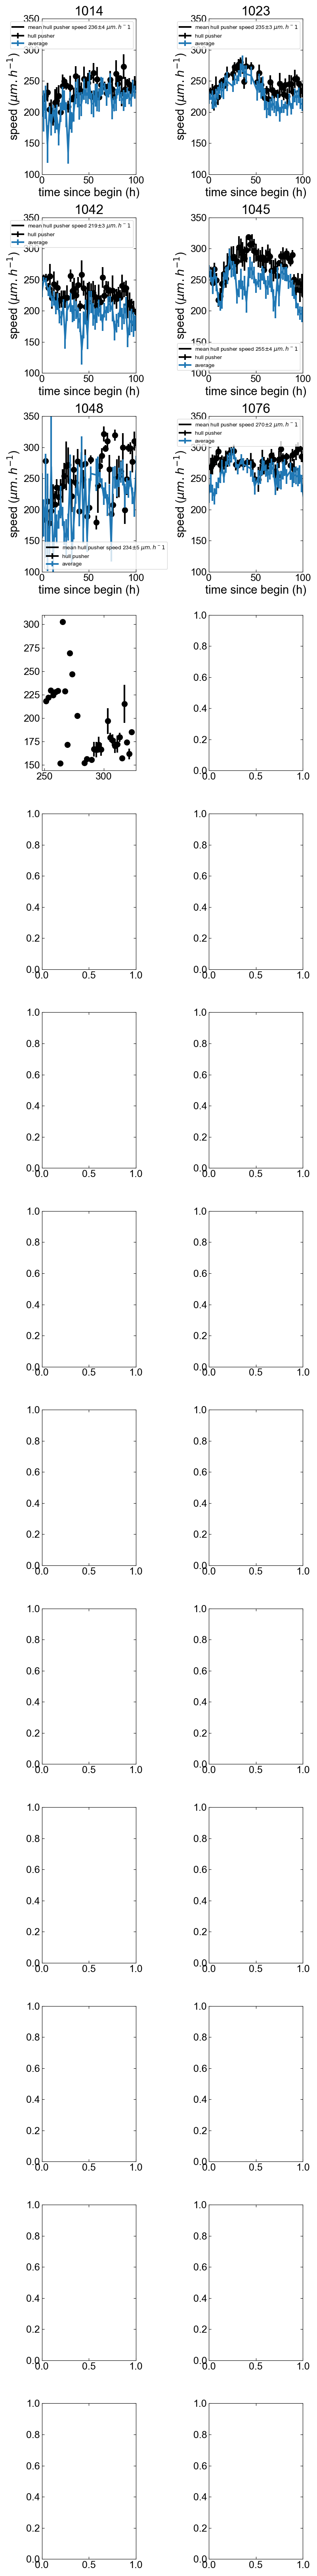

In [6]:
ncols = 2
fig,axs = gridplot(len(plates),ncols = ncols,subh = 5,subw = 4)
ax_list = list(axs)
min_time = {plate_id : 0 for plate_id in plates}
max_time = {plate_id : 100 for plate_id in plates}
min_time['799_20211001'] = 100
max_time['799_20211001'] = 200
hull_speeds_dic = {}
hull_time_dic = {}
datas = {}
dys = {}
# plates += ["558_20230109"]

for j in range(len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id']==int(plate_id)]
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)]
    data,dy,select_movements = get_average_time_data(int(plate_id),time_hypha_plate,2)
    hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
    if len(hyphae_hull)>0:
        label = 'hull pusher'
        for t in (time_plate_info_plate['timestep'].unique()):
            if t>=1 and t<max((time_plate_info_plate['timestep'].unique())):
                select = time_hypha_plate.loc[time_hypha_plate['timestep'].astype(int)==t]
                select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
                select = select.loc[select['speed'].between(150,350)]
                if len(select)>0:
                    time = select['time_since_begin_h'].iloc[0]
                    # if time/pd.Timedelta(hours = 1)<=max_time[plate_id] and time/pd.Timedelta(hours = 1)>=min_time[plate_id]:
                    ax.scatter(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),color='black')
                    ax.errorbar(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
                    label = None
                    hull_speeds.append(np.mean(select["speed"]))
                    hull_time.append(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1))

                    select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
                else:
                    hull_speeds.append(np.nan)
                    hull_time.append(np.nan)
            else:
                hull_speeds.append(np.nan)
                hull_time.append(np.nan)
        
                # select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
        # ax.plot(data.index/pd.Timedelta(hours = 1),data)
        ax.errorbar(data.index/pd.Timedelta(hours = 1),data, yerr=dy,label='average')
        ax.set_xlim(0,150)
        ax.set_ylim(100,350)

        ax.legend()
        # ax.set_title(f'{plate}')
        ax.set_xlabel('time since begin (h)')
        ax.set_ylabel('speed ($\mu m.h^{-1}$)')
            # break
        ax.set_xlim(0,100)
        plt.tight_layout()
        if len(hull_speeds)>0:
            ax.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
                    color="black",
                    label= f'mean hull pusher speed {int(np.nanmean(hull_speeds))}$\pm${int(2*np.nanstd(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')
            ax.legend()
    datas[plate] = data
    dys[plate] = dy
    hull_speeds_dic[plate] = hull_speeds
    hull_time_dic[plate] = hull_time
    # ax.patch.set_facecolor(get_color(plate,folders))
    # ax.patch.set_alpha(0.1)
    ax.set_title(plate)
    plt.tight_layout()
    analysis_dir = analysis_folders.loc[analysis_folders['unique_id']==plate_id]["total_path"].iloc[0]    # break
    path_save = os.path.join(analysis_dir, "time_plate_info.json")
    table = pd.read_json(path_save)
    table = table.transpose()
    table = table.fillna(-1)
    table = table.copy()
    total = hull_speeds

    table["hull_speed"] = total
    table = table.transpose()
    table.to_json(path_save)
    # plt.savefig(f'Figure/FigureS2C.svg')    

In [ ]:
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100,206 : 90,202 : 100,218 : 100,219 :100,229 :100}
timestep = {**timestep, **timestep2}
timestep2 = {850:100,840:100,861:100}
timestep = {**timestep, **timestep2}
timestep2 = {462:100,532:100}
timestep = {**timestep, **timestep2}
timestep2 = {527:100,537:100,558:100}
timestep = {**timestep, **timestep2}

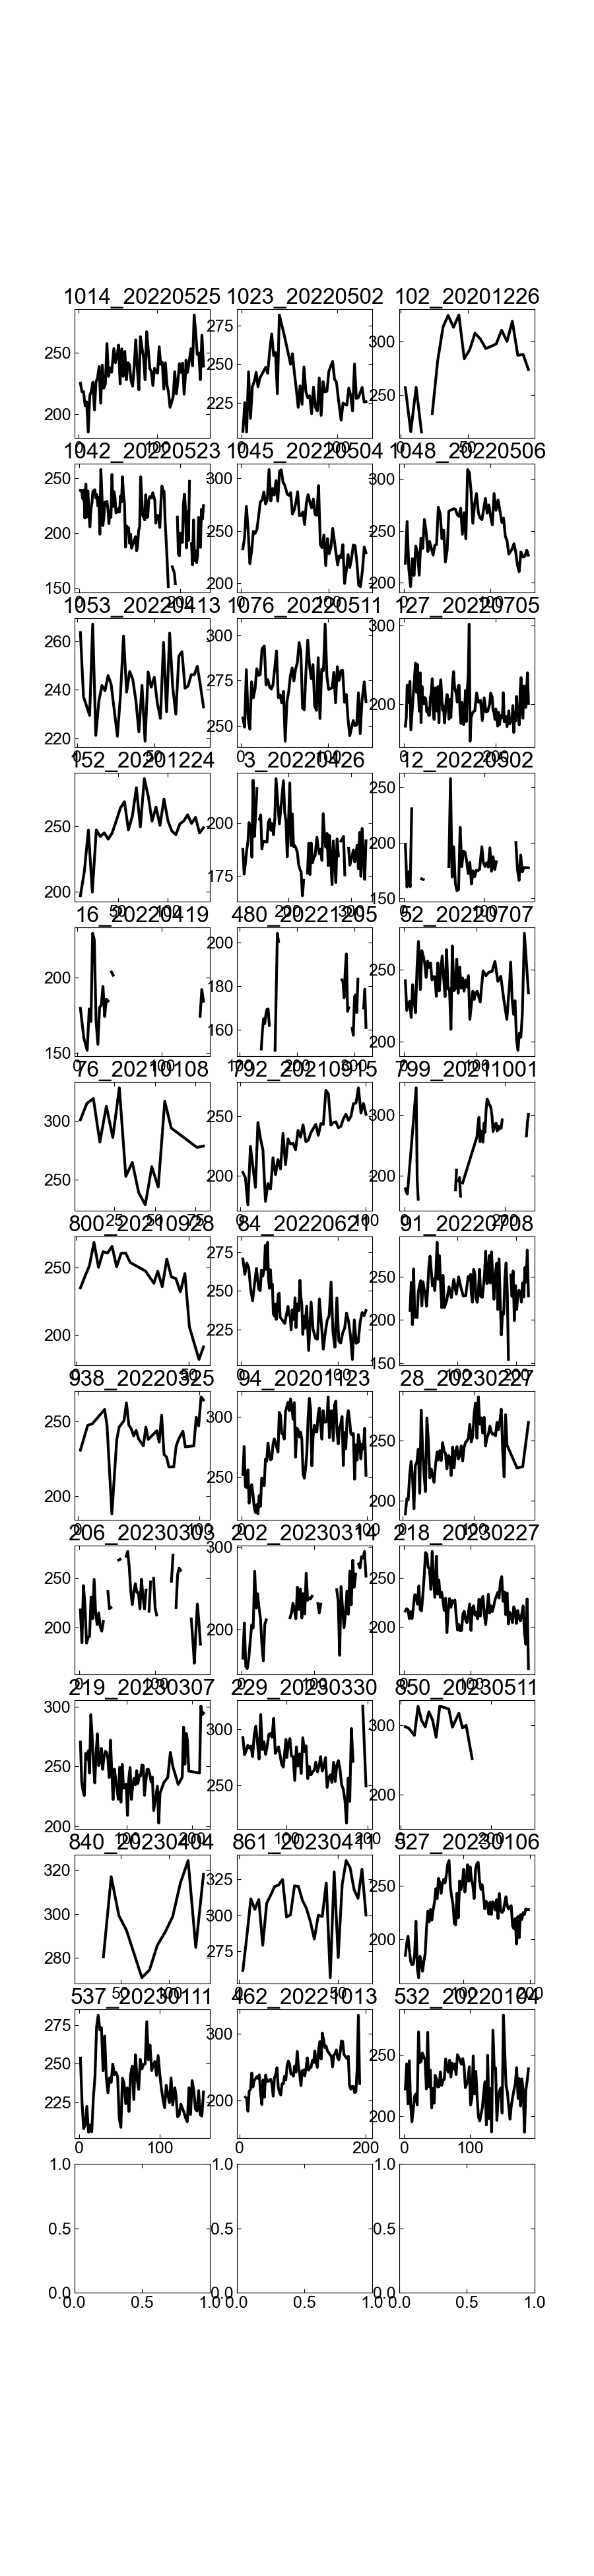

In [4]:
ncols = 3

time_plate_info = time_plate_info.replace(-1.0,np.nan)

fig,axs = gridplot(len(plates)+1,ncols = ncols,subh = 3,subw = 3)
ax_list = list(axs)
plate_speeds = {}
for j in range(0,len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)]
    time_plate_info_plate = time_plate_info_plate.loc[time_plate_info_plate['timestep']<timestep[plate]]
    ax.plot(time_plate_info_plate['time_since_begin_h'],time_plate_info_plate['hull_speed'],
                    color="black")
    ax.set_title(plate_id)
    plate_speeds[plate_id] = np.nanmedian(time_plate_info_plate['hull_speed'])

In [5]:
time_plate_info["density"] = time_plate_info["tot_length_study"]/time_plate_info["area_sep_comp"]
time_plate_info["density_biovolume"] = time_plate_info["tot_biovolume_study"]/time_plate_info["area_sep_comp"]



C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


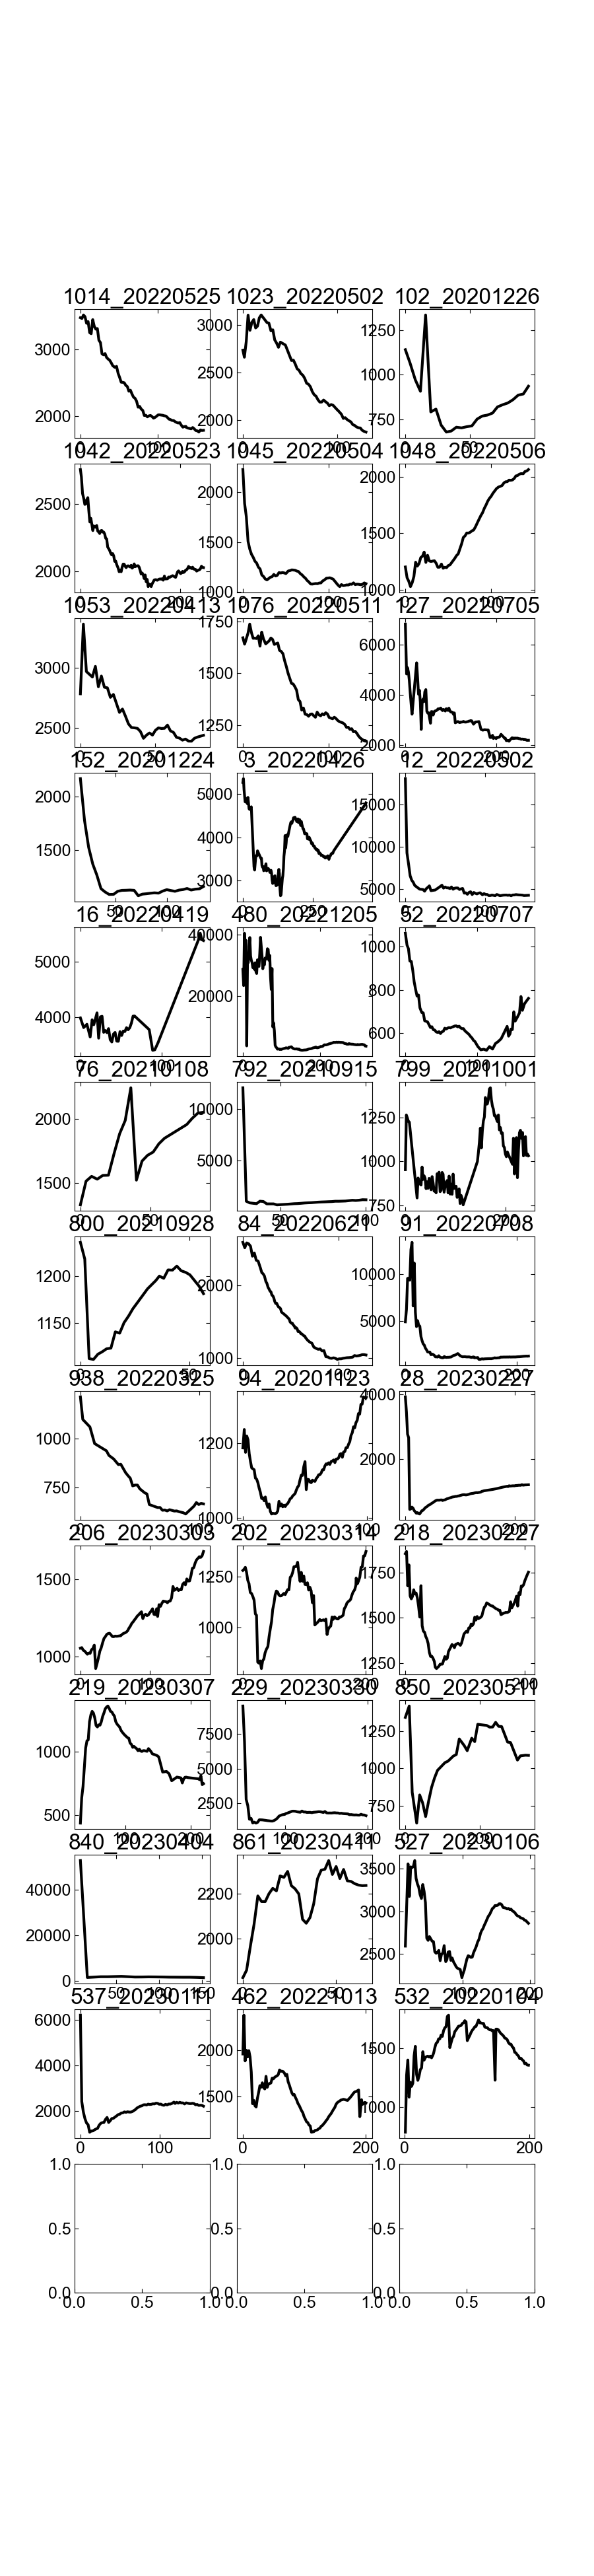

In [6]:
time_plate_info = time_plate_info.replace(-1.0,np.nan)

fig,axs = gridplot(len(plates)+1,ncols = ncols,subh = 3,subw = 3)
ax_list = list(axs)
plate_density = {}
plate_density_biov = {}
plate_strain = {}
plate_start = {}
for j in range(0,len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)]
    folders_plate = folders.loc[folders['unique_id']==int(plate_id)]
    time_plate_info_plate = time_plate_info_plate.loc[time_plate_info_plate['timestep']<timestep[plate]]
    ax.plot(time_plate_info_plate['time_since_begin_h'],time_plate_info_plate['density'],
                    color="black")
    time_plate_info_plate_median = time_plate_info_plate.loc[time_plate_info_plate['timestep']>=min(max(time_plate_info_plate['timestep']),timestep[plate]-10)]

    plate_density[plate_id] = np.nanmedian(time_plate_info_plate_median['density'])
    plate_density_biov[plate_id] = np.nanmedian(time_plate_info_plate_median['density_biovolume']) 
    plate_strain[plate_id] = folders_plate['strain'].iloc[0]
    plate_start[plate_id] = folders_plate['CrossDate'].iloc[0]
    ax.set_title(plate_id)
    # break

In [7]:
def ZMUV(signal):
    return((signal-np.mean(signal))/np.std(signal))

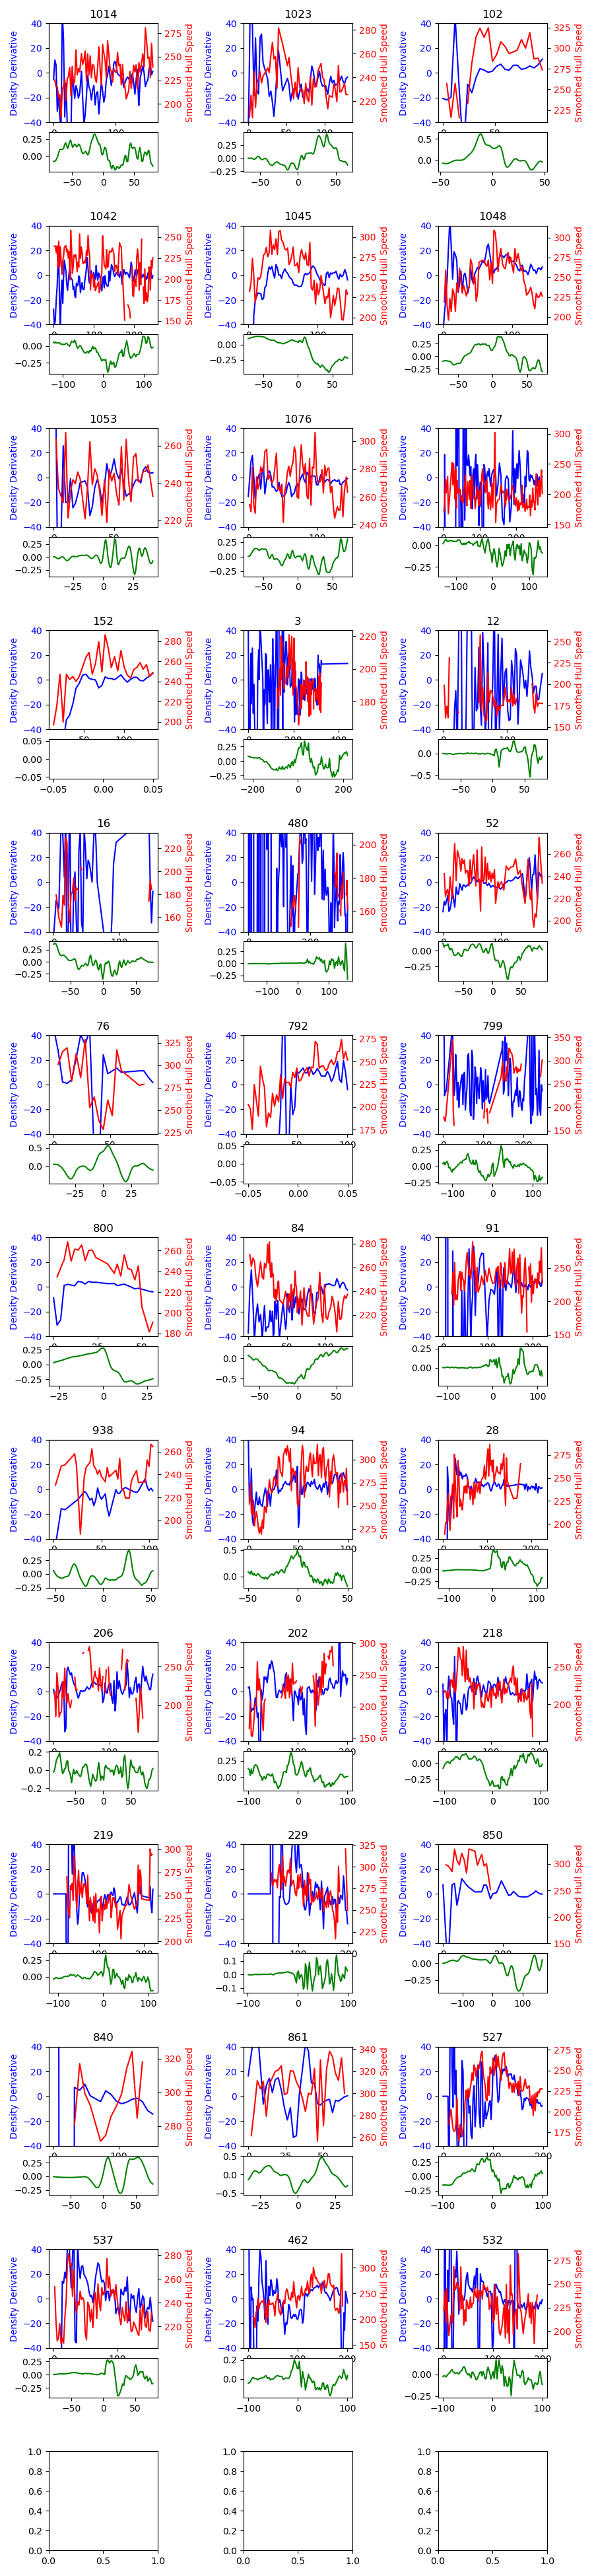

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter  # For smoothing
from scipy.signal import medfilt
from scipy.signal import savgol_filter, correlate, medfilt
time_plate_info = time_plate_info.replace(-1.0,np.nan)

fig,axs = gridplot(len(plates)+1,ncols = ncols,subh = 3,subw = 3)
ax_list = list(axs)
for j in range(0,len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)]
    folders_plate = folders.loc[folders['unique_id']==int(plate_id)]
    time_plate_info_plate = time_plate_info_plate.loc[time_plate_info_plate['timestep']<timestep[plate]]
    # Sample data (replace this with your actual data)
    time_data = time_plate_info_plate['time_since_begin_h']
    density_data = time_plate_info_plate['density']
    hull_speed_data = time_plate_info_plate['hull_speed']
    density_data = density_data.replace(np.inf,np.median(density_data))
    # smoothed_density = medfilt(density_data, kernel_size=11)
    # Calculate the derivative of density
    density_derivative = np.gradient(density_data, time_data)

    # Apply Savitzky-Golay smoothing to the hull speed data

    # Create the plot

    # Plot the density derivative
    ax.plot(time_data, density_derivative, color='blue', label='Density Derivative')
    ax.set_xlabel('Time')
    ax.set_ylabel('Density Derivative', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_ylim(-40,40)
    # Create a twin Axes sharing the xaxis for the hull speed
    ax2 = ax.twinx()
    ax2.plot(time_data, hull_speed_data, color='red', label='Smoothed Hull Speed')
    ax2.set_ylabel('Smoothed Hull Speed', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax.set_title(plate)
    time_series = pd.Series(time_data)
    hull_speed_series = pd.Series(hull_speed_data)

    # Interpolate missing values
    hull_speed_series = hull_speed_series.fillna(np.nanmedian(hull_speed_series))

    # Now you can interpolate to the new grid
    max_time,min_time = np.max(time_data),np.min(time_data)
    range_time = max_time-min_time
    common_time_grid = np.linspace(min_time, max_time, num=100)  # Adjust num as needed
    resampled_speed = np.interp(common_time_grid, time_series, hull_speed_series)
    resampled_dens_grad= np.interp(common_time_grid, time_data, density_derivative)

    signal1 = ZMUV(resampled_speed)
    signal2 = ZMUV(resampled_dens_grad)
    
    xcorr = correlate(signal1, signal2, mode='same')
    xcorr = xcorr/len(xcorr)
    # Create an axis below the main plot for cross-correlation
    ax_xcorr = ax_list[j].inset_axes([0, -0.5, 1, 0.4])  # [x, y, width, height]


    time_lags = np.linspace(-range_time/2, range_time/2, len(common_time_grid))

    ax_xcorr.plot(time_lags, xcorr, label='Cross-Correlation', color='green')
    # ax_xcorr.set_title("Cross-correlation")
    # ax_xcorr.axis('off')  # Hide the axis to make it cleaner
    # break
    
plt.tight_layout()



In [12]:
colors = {"'A5'" : "red","'A5sp3'" :"red","'C2'":"blue","'Agg'" : "black","'Clarum'" : 'green',"'C3'" : "purple","'B12'" : "yellow",
        "'4350'" : 'pink',
          "'D1'" : "brown"
         }

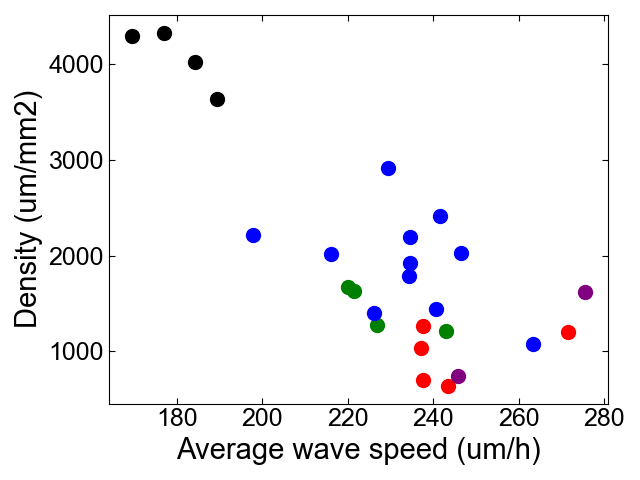

In [17]:
fig,ax = plt.subplots()
for j in range(0,len(plates)):
    plate_id=plates[j]
    if type(plate_start[plate_id]) == int and plate_start[plate_id]>=20220101:

        ax.scatter(plate_speeds[plate_id],plate_density[plate_id],color = colors[plate_strain[plate_id]])
        # ax.text(plate_speeds[plate_id],plate_density[plate_id],plate_id)
ax.set_xlabel('Average wave speed (um/h)')
ax.set_ylabel('Density (um/mm2)')
plt.tight_layout()

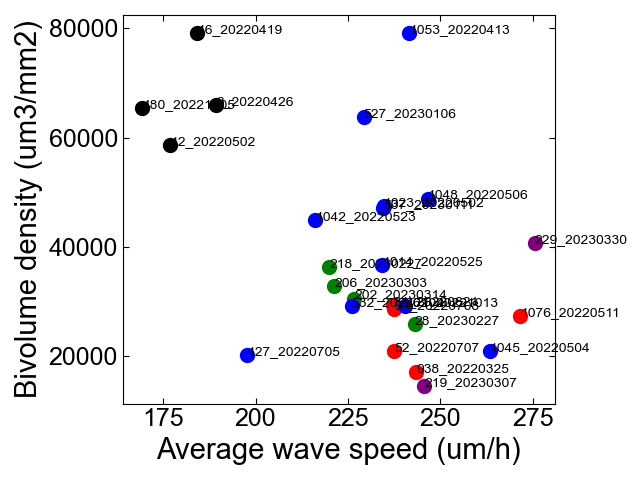

In [15]:
fig,ax = plt.subplots()
for j in range(0,len(plates)):
    plate_id=plates[j]
    if type(plate_start[plate_id]) == int and plate_start[plate_id]>=20220101:
        ax.scatter(plate_speeds[plate_id],plate_density_biov[plate_id],color = colors[plate_strain[plate_id]])
        ax.text(plate_speeds[plate_id],plate_density_biov[plate_id],plate_id)
ax.set_xlabel('Average wave speed (um/h)')
ax.set_ylabel('Bivolume density (um3/mm2)')
plt.tight_layout()

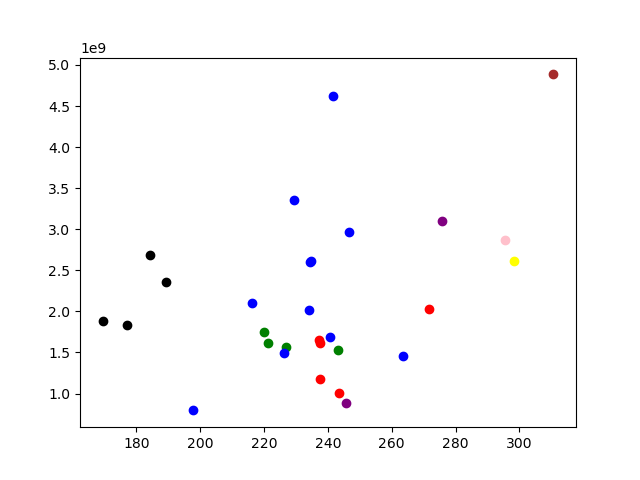

In [25]:
fig,ax = plt.subplots()
for j in range(0,len(plates)):
    plate_id=plates[j]
    if type(plate_start[plate_id]) == int and plate_start[plate_id]>=20220101:
        ax.scatter(plate_speeds[plate_id],plate_density_biov[plate_id]*plate_speeds[plate_id]**2,color = colors[plate_strain[plate_id]])

In [189]:
growth_coefficients = [plate_density_biov[plate_id]*plate_speeds[plate_id]**2 for plate_id in plates]
speeds =  [plate_speeds[plate_id] for plate_id in plates]
densities = [plate_density[plate_id] for plate_id in plates]

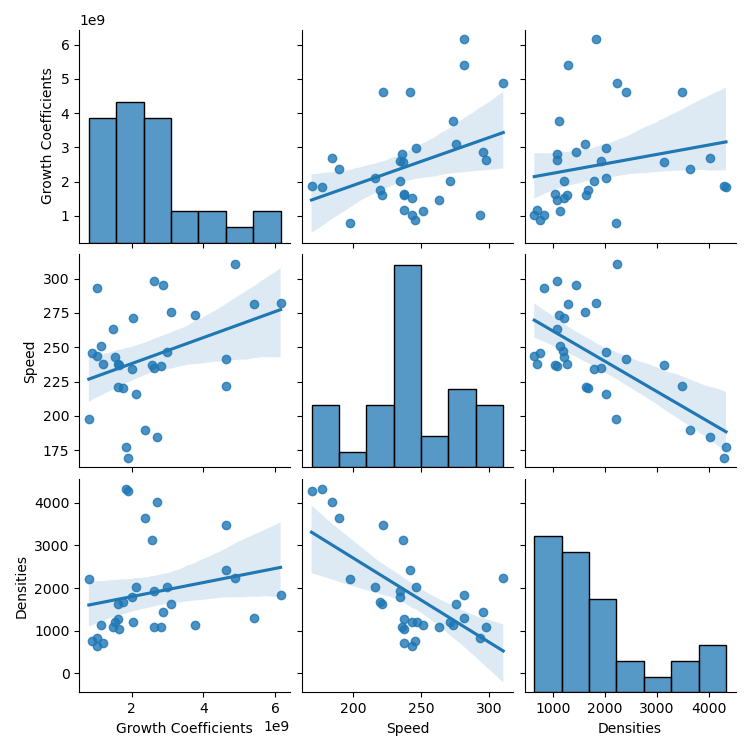

In [191]:
import seaborn as sns
data = pd.DataFrame({'Growth Coefficients': growth_coefficients,
                     'Speed': speeds,
                     'Densities': densities})

# Create the scatter plot matrix with regression lines
sns.pairplot(data, kind='reg')

In [22]:
for plate in plates:
    fig,ax = plt.subplots()
    
    select = time_plate_info.loc[time_plate_info["unique_id"] == int(plate)]
    # Ds[plate] = select["density"].iloc[timestep[int(plate.split('_')[0])]]
    ax.plot(select["timestep"],select["density"])
    ax.set_title(plate)

In [30]:
total = [np.nan]+hull_speeds+[np.nan]*2
len(total)

100

In [42]:
table["hull_speed"]

0      -1.000000
1     225.182090
2     218.162858
3     218.295316
4     206.837753
         ...    
95    254.297396
96    267.683245
97    216.478273
98     -1.000000
99     -1.000000
Name: hull_speed, Length: 100, dtype: float64

In [40]:
table = table.transpose()
table.to_json(path_save)